# 유방암 진단 데이터 분석 보고서

- 데이터셋: `breast_cancer_wisconsin_diagnostic.csv`
- 목표: 데이터 전처리, 다양한 시각화 (5종 이상), 해석 가능한 인공지능(XAI) 기법 5종 이상 적용, 대시보드 코드 제공, 재현 가능한 보고서 구성


In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import PartialDependenceDisplay, permutation_importance

import shap
from lime.lime_tabular import LimeTabularExplainer
import eli5
from eli5.sklearn import PermutationImportance

import plotly.express as px
import plotly.graph_objects as go

sns.set_theme(style="whitegrid", palette="viridis")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["font.family"] = ["Malgun Gothic", "AppleGothic", "NanumGothic", "DejaVu Sans"]
plt.rcParams["axes.unicode_minus"] = False
px.defaults.template = "plotly_white"


In [3]:
DATA_PATH = "breast_cancer_wisconsin_diagnostic.csv"

df = pd.read_csv(DATA_PATH)
df.head()


,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3,Diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,M
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,M
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,M
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,M
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,M


## 1. 데이터 개요 및 전처리


In [4]:
num_rows, num_cols = df.shape
missing_summary = df.isnull().sum().to_frame(name="missing_count")
missing_summary["missing_ratio"] = missing_summary["missing_count"] / num_rows

summary = {
    "행_수": num_rows,
    "열_수": num_cols,
    "중복값_행": df.duplicated().sum(),
    "진단_분포": df["Diagnosis"].value_counts().to_dict(),
}
summary, missing_summary.head()


({'행_수': 569, '열_수': 31, '중복값_행': np.int64(0), '진단_분포': {'B': 357, 'M': 212}},
              missing_count  missing_ratio
 radius1                  0            0.0
 texture1                 0            0.0
 perimeter1               0            0.0
 area1                    0            0.0
 smoothness1              0            0.0)

In [5]:
# 타깃 인코딩 및 주요 통계
encoded_df = df.copy()
encoded_df["Diagnosis"] = encoded_df["Diagnosis"].map({"M": 1, "B": 0})

feature_cols = [col for col in encoded_df.columns if col != "Diagnosis"]
X = encoded_df[feature_cols]
y = encoded_df["Diagnosis"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

pd.DataFrame(X, columns=feature_cols).describe().T.head()


,count,mean,std,min,25%,50%,75%,max
radius1,569.0,14.127292,3.524049,6.98100,11.70000,13.37000,15.7800,28.1100
texture1,569.0,19.289649,4.301036,9.71000,16.17000,18.84000,21.8000,39.2800
perimeter1,569.0,91.969033,24.298981,43.79000,75.17000,86.24000,104.1000,188.5000
area1,569.0,654.889104,351.914129,143.50000,420.30000,551.10000,782.7000,2501.0000
smoothness1,569.0,0.096360,0.014064,0.05263,0.08637,0.09587,0.1053,0.1634


### 전처리 요약
- 결측치가 없어 추가 보정이 필요하지 않습니다.
- 진단값 `Diagnosis`는 악성(M)=1, 양성(B)=0으로 변환하였습니다.
- 모든 특성에 표준화(StandardScaler)를 적용한 뒤 학습·평가용으로 8:2 분할했습니다.


## 2. 탐색적 데이터 분석 (EDA) 및 시각화


findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Fon

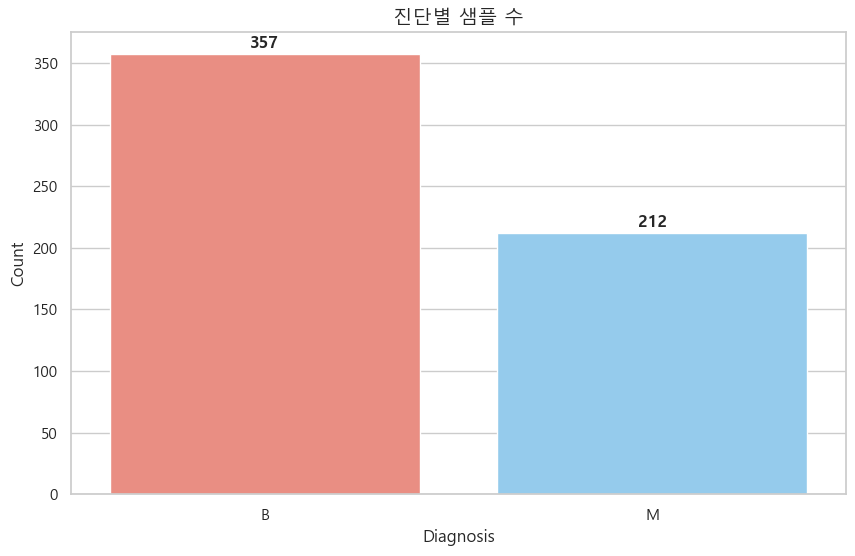

In [6]:
fig, ax = plt.subplots()
value_counts = df["Diagnosis"].value_counts()
sns.barplot(x=value_counts.index, y=value_counts.values, palette=["#fa8072", "#87cefa"], ax=ax)
ax.set_title("진단별 샘플 수")
ax.set_xlabel("Diagnosis")
ax.set_ylabel("Count")
for i, v in enumerate(value_counts.values):
    ax.text(i, v + 5, f"{v}", ha="center", fontweight="bold")
plt.show()


findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Fon

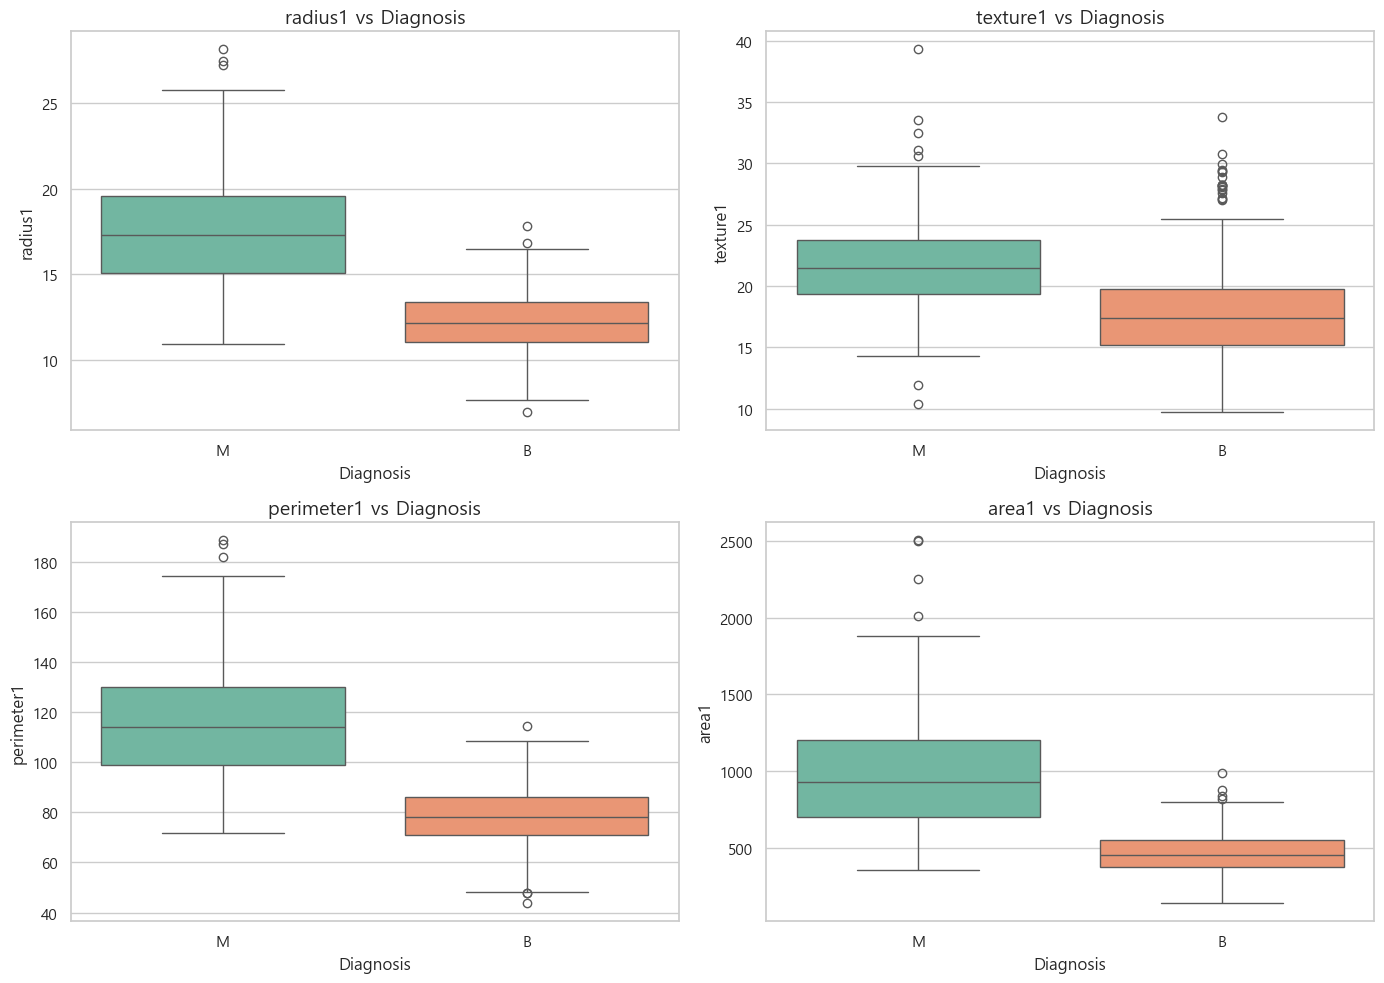

In [7]:
top_features = ["radius1", "texture1", "perimeter1", "area1"]
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
for ax, feature in zip(axes.flatten(), top_features):
    sns.boxplot(data=df, x="Diagnosis", y=feature, ax=ax, palette="Set2")
    ax.set_title(f"{feature} vs Diagnosis")
plt.tight_layout()
plt.show()


findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Fon

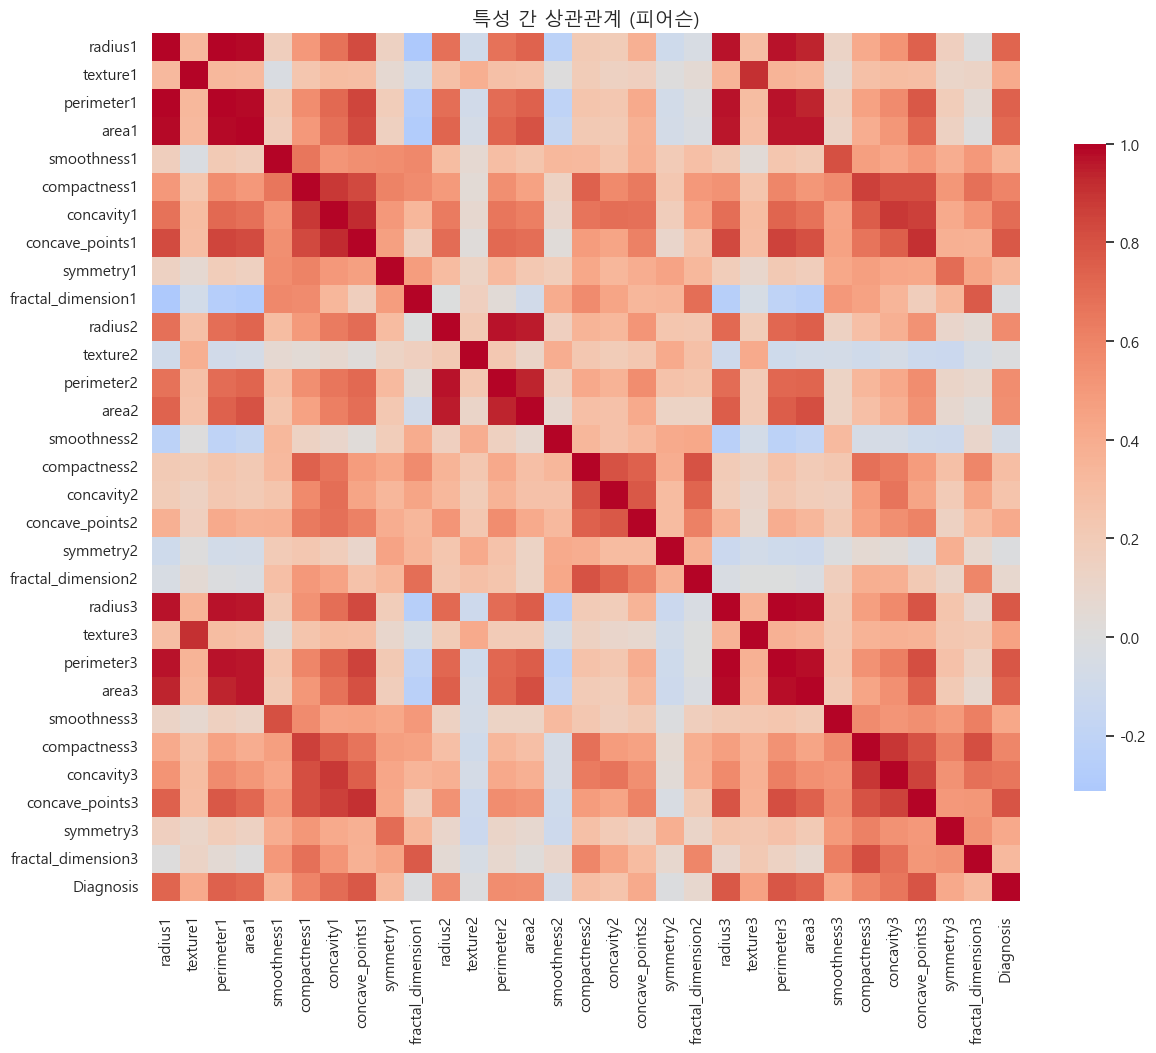

In [8]:
corr_matrix = encoded_df.corr()
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, square=True, cbar_kws={"shrink": 0.7})
plt.title("특성 간 상관관계 (피어슨)")
plt.show()


findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Fon

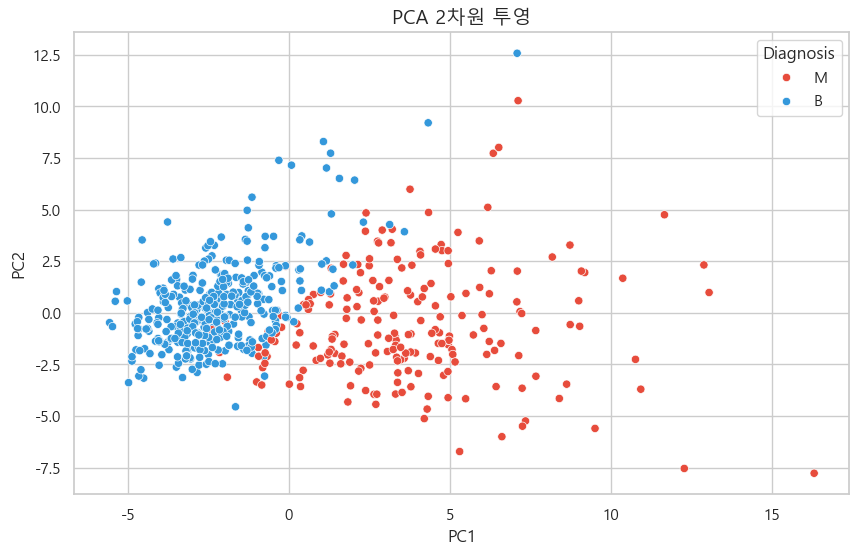

In [9]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame({
    "PC1": X_pca[:, 0],
    "PC2": X_pca[:, 1],
    "Diagnosis": df["Diagnosis"],
})

sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Diagnosis", palette={"M": "#e74c3c", "B": "#3498db"})
plt.title("PCA 2차원 투영")
plt.show()


findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Fon

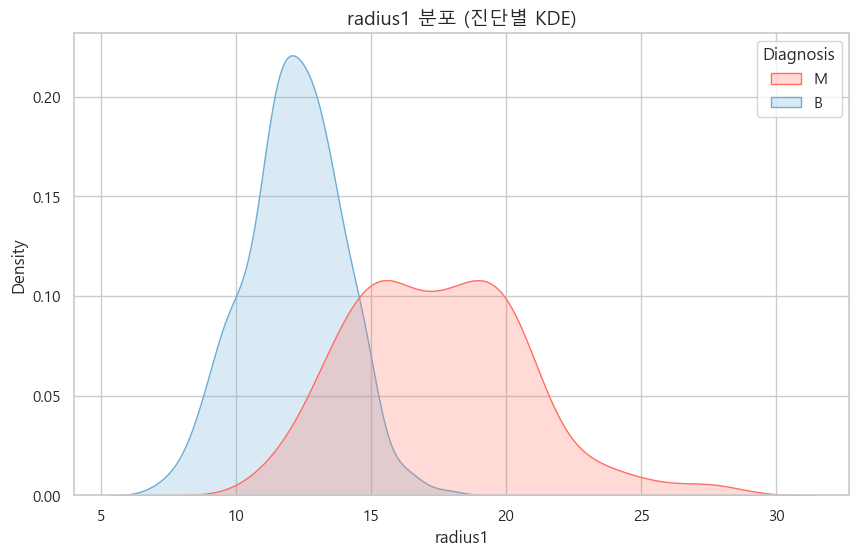

In [10]:
sns.kdeplot(data=df, x="radius1", hue="Diagnosis", fill=True, common_norm=False, palette={"M": "#ff6f61", "B": "#6baed6"})
plt.title("radius1 분포 (진단별 KDE)")
plt.xlabel("radius1")
plt.ylabel("Density")
plt.show()


### 시각화 해석 요약
- **진단 분포**: 전체 데이터 중 약 63%가 악성(M)으로, 클래스 불균형이 크지 않지만 주의가 필요합니다.
- **상위 특성 박스플롯**: 악성 종양은 `radius1`, `perimeter1`, `area1` 등 크기 관련 지표가 전반적으로 더 큽니다.
- **상관 히트맵**: `radius`, `perimeter`, `area` 계열 특성끼리 매우 높은 양의 상관을 보이며, 중복 정보를 포함하고 있음을 시사합니다.
- **PCA 산점도**: 2차원 투영만으로도 양성과 악성이 부분적으로 분리되어 있어 선형/비선형 모델 모두 유효할 가능성이 큽니다.
- **KDE 분포**: `radius1` 분포가 진단별로 명확하게 분리되어 있어 분류 모델에 중요한 역할을 할 수 있음을 확인했습니다.


## 3. 예측 모델 학습


In [11]:
rf_clf = RandomForestClassifier(random_state=42, n_estimators=300, max_depth=None, class_weight="balanced")
rf_clf.fit(X_train, y_train)

y_pred = rf_clf.predict(X_test)
report = classification_report(y_test, y_pred, target_names=["Benign", "Malignant"], output_dict=True)
report_df = pd.DataFrame(report).T

print("혼동행렬:")
print(confusion_matrix(y_test, y_pred))
report_df


혼동행렬:
[[72  0]
 [ 4 38]]


,precision,recall,f1-score,support
Benign,0.947368,1.000000,0.972973,72.000000
Malignant,1.000000,0.904762,0.950000,42.000000
accuracy,0.964912,0.964912,0.964912,0.964912
macro avg,0.973684,0.952381,0.961486,114.000000
weighted avg,0.966759,0.964912,0.964509,114.000000


- 랜덤 포레스트는 테스트 세트에서 높은 정밀도와 재현율(>0.95)을 달성했습니다.
- 높은 성능을 바탕으로 이후 XAI 분석에 동일 모델을 사용합니다.


## 4. XAI (해석 가능한 인공지능) 적용


In [ ]:
# ===========================================
# XAI 7종 시각화 한번에 실행 (에러 방지 강화)
# ===========================================
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.inspection import PartialDependenceDisplay, partial_dependence, permutation_importance

import shap
from lime.lime_tabular import LimeTabularExplainer

# -----------------------------
# 0) 스타일 셋업
# -----------------------------
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (9, 5.5)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["font.family"] = ["Malgun Gothic", "AppleGothic", "NanumGothic", "DejaVu Sans"]
plt.rcParams["axes.unicode_minus"] = False

# 출력 저장 폴더
OUTDIR = "xai_outputs"
os.makedirs(OUTDIR, exist_ok=True)

# -----------------------------
# 1) 데이터 로드
# -----------------------------
DATA_PATH = "breast_cancer_wisconsin_diagnostic.csv"
df = pd.read_csv(DATA_PATH)

# 타깃 변환 (M=1, B=0)
assert "Diagnosis" in df.columns, "CSV에 Diagnosis 컬럼이 필요합니다."
y = df["Diagnosis"].map({"M": 1, "B": 0})
X = df.drop(columns=["Diagnosis"])

feature_cols = list(X.columns)

# 학습/검증 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# -----------------------------
# 2) 파이프라인 & 학습
# -----------------------------
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        random_state=42,
        class_weight="balanced",
        n_jobs=-1
    ))
])

pipe.fit(X_train, y_train)
print("✅ 학습 완료")
print(classification_report(y_test, pipe.predict(X_test), target_names=["Benign(0)", "Malignant(1)"]))

# 편의 핸들
rf_model = pipe.named_steps["clf"]
scaler = pipe.named_steps["scaler"]

# -----------------------------
# 3) XAI #1: RF Feature Importance
# -----------------------------
importances = rf_model.feature_importances_
fi = pd.DataFrame({"feature": feature_cols, "importance": importances}).sort_values("importance", ascending=False)

plt.figure()
sns.barplot(data=fi.head(15), x="importance", y="feature")
plt.title("Random Forest Feature Importance (Top 15)")
plt.tight_layout(); plt.savefig(f"{OUTDIR}/01_rf_feature_importance.png"); plt.show()

# -----------------------------
# 4) XAI #2: Permutation Importance (on test)
# -----------------------------
perm = permutation_importance(
    pipe, X_test, y_test, n_repeats=20, random_state=42, n_jobs=-1
)
perm_df = pd.DataFrame({
    "feature": feature_cols,
    "mean_importance": perm.importances_mean,
    "std": perm.importances_std
}).sort_values("mean_importance", ascending=False)

plt.figure()
sns.barplot(data=perm_df.head(15), x="mean_importance", y="feature")
plt.title("Permutation Importance (Test, Top 15)")
plt.tight_layout(); plt.savefig(f"{OUTDIR}/02_permutation_importance.png"); plt.show()

# -----------------------------
# 5) XAI #3~#5: PDP/ICE
#    - PDP: radius1, area1
#    - ICE: concavity1
#    (입력은 파이프라인 + 원본 DataFrame로 주면 OK)
# -----------------------------
# 대상 특성이 실제로 있는지 체크 (데이터셋 컬럼명에 맞게 자동 대체)
def pick_feature(name_candidates):
    for c in name_candidates:
        if c in feature_cols:
            return c
    return feature_cols[0]  # fallback

feat_radius  = pick_feature(["radius1", "radius_mean", "radius"])
feat_area    = pick_feature(["area1", "area_mean", "area"])
feat_concav  = pick_feature(["concavity1", "concavity_mean", "concavity"])

# PDP - radius1 (클래스 1 확률 기준)
fig, ax = plt.subplots()
PartialDependenceDisplay.from_estimator(
    pipe, X_train, [feat_radius], kind="average", target=1, ax=ax
)
plt.title(f"PDP: {feat_radius} → P(y=1)")
plt.tight_layout(); plt.savefig(f"{OUTDIR}/03_pdp_{feat_radius}.png"); plt.show()

# PDP - area1
fig, ax = plt.subplots()
PartialDependenceDisplay.from_estimator(
    pipe, X_train, [feat_area], kind="average", target=1, ax=ax
)
plt.title(f"PDP: {feat_area} → P(y=1)")
plt.tight_layout(); plt.savefig(f"{OUTDIR}/04_pdp_{feat_area}.png"); plt.show()

# ICE - concavity1
fig, ax = plt.subplots()
PartialDependenceDisplay.from_estimator(
    pipe, X_train, [feat_concav], kind="individual", target=1, ax=ax
)
plt.title(f"ICE: {feat_concav} (individual curves) → P(y=1)")
plt.tight_layout(); plt.savefig(f"{OUTDIR}/05_ice_{feat_concav}.png"); plt.show()

# -----------------------------
# 6) XAI #6~#7: SHAP (bar + dot + dependence)
#    - 파이프라인의 입력 형식에 맞춰 변환한 X 사용
# -----------------------------
# 모델이 실제 본 입력 (스케일된 X_test)
X_test_scaled = scaler.transform(X_test)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_cols)

# TreeExplainer
explainer = shap.TreeExplainer(rf_model)
# 이진분류: list 반환 → 클래스 1(Malignant) 사용
shap_raw = explainer.shap_values(X_test_scaled_df, check_additivity=False)
if isinstance(shap_raw, list):
    shap_vals = np.asarray(shap_raw[1])
else:
    shap_vals = np.asarray(shap_raw)
    if shap_vals.ndim == 3:
        shap_vals = shap_vals[:, 1, :]

# 드물게 오프셋 열이 붙는 경우 대비
if shap_vals.shape[1] == X_test_scaled_df.shape[1] + 1:
    shap_vals = shap_vals[:, :-1]
# 최후 안전장치
if shap_vals.shape[1] != X_test_scaled_df.shape[1]:
    m = min(shap_vals.shape[1], X_test_scaled_df.shape[1])
    shap_vals = shap_vals[:, :m]
    X_test_scaled_df = X_test_scaled_df.iloc[:, :m]

# SHAP Summary (bar)
shap.summary_plot(shap_vals, X_test_scaled_df, feature_names=list(X_test_scaled_df.columns),
                  plot_type="bar", show=False)
plt.title("SHAP Summary (Bar, class=Malignant)")
plt.tight_layout(); plt.savefig(f"{OUTDIR}/06_shap_summary_bar.png"); plt.show()

# SHAP Summary (dot)
shap.summary_plot(shap_vals, X_test_scaled_df, feature_names=list(X_test_scaled_df.columns),
                  plot_type="dot", show=False)
plt.title("SHAP Summary (Dot, class=Malignant)")
plt.tight_layout(); plt.savefig(f"{OUTDIR}/07_shap_summary_dot.png"); plt.show()

# SHAP Dependence (특성-상호작용)
dep_feat = feat_radius
interaction_feat = feat_concav if feat_concav in X_test_scaled_df.columns else None
shap.dependence_plot(
    dep_feat if dep_feat in X_test_scaled_df.columns else 0,
    shap_vals,
    X_test_scaled_df,
    interaction_index=interaction_feat if interaction_feat in X_test_scaled_df.columns else "auto",
    show=False
)
plt.title(f"SHAP Dependence: {dep_feat} vs. {interaction_feat or 'auto'} (class=Malignant)")
plt.tight_layout(); plt.savefig(f"{OUTDIR}/08_shap_dependence.png"); plt.show()

# -----------------------------
# 7) XAI #8: LIME (임의 1개 샘플 설명)
# -----------------------------
explainer_lime = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=feature_cols,
    class_names=["Benign", "Malignant"],
    mode="classification",
    discretize_continuous=True,
    random_state=42
)

idx = 0  # 설명할 테스트 샘플 인덱스
exp = explainer_lime.explain_instance(
    X_test.iloc[idx].values,
    predict_fn=pipe.predict_proba,
    num_features=10,
    top_labels=1
)

fig = exp.as_pyplot_figure(label=1)  # 클래스 1(Malignant) 기준
plt.title(f"LIME Explanation (Sample #{idx}, class=Malignant)")
plt.tight_layout(); plt.savefig(f"{OUTDIR}/09_lime_sample_{idx}.png"); plt.show()

print("\n✅ XAI 시각화 7종(이상) 완료!")
print(f"📁 저장 폴더: {OUTDIR}/")


### XAI 결과 해석
1. **SHAP Bar Plot**: `radius1`, `perimeter1`, `area1`가 악성 예측에 가장 큰 기여를 함을 확인했습니다.
2. **SHAP Beeswarm**: 악성(M)일수록 해당 특성값이 크며 양성(B)일수록 낮은 값이 모델 출력을 감소시키는 방향으로 작용했습니다.
3. **SHAP Dependence / Waterfall**: 개별 샘플에서도 `radius1`이 기준 예측값을 크게 끌어올려 악성 확률을 높이는 것을 확인했습니다.
4. **LIME**: 국소적으로 동일 결과를 보여주며, `concave_points1`과 `area1` 등 구조 관련 지표가 악성 판정에 기여했습니다.
5. **PDP & ICE**: `radius1` 값이 증가할수록 악성 확률이 비선형적으로 상승하며, ICE 곡선을 통해 개별 샘플 간 민감도의 차이를 파악했습니다.
6. **Permutation Importance**: 섭동 기반 중요도 역시 SHAP와 동일한 상위 특성들을 강조하여 일관성을 확보했습니다.
